# Permutation test: 
## Adjusted gene expression and mitonuclear DNA discordance (independent of population)
- Fig. 3: Permutation test (skeletal muscle), and table of all tissues.

In [1]:
import pandas as pd
#pd.set_option("display.max_rows", None, "display.max_columns", None)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import statistics
#import statsmodels.api as sm
from itertools import permutations
#import pdfkit as pdf
import statsmodels.graphics.gofplots as sm
import pingouin as pg

import seaborn as sns; sns.set(style="ticks", color_codes=True)

from Bio import SeqIO
import sys

### List of tissues and genes.

In [2]:
list_tissues = [ 'Muscle - Skeletal','Esophagus - Muscularis','Artery - Tibial','Nerve - Tibial','Whole Blood','Heart - Left Ventricle','Heart - Atrial Appendage' ]

# Exclude ND5 and ND6 from list.
list_mtdna = [ 'ATP6','ATP8','CO1','CO2','CO3','CYB','ND1','ND2','ND3','ND4','ND4L' ]

## Import file with adjusted expression.
- Requires GTEx ID, population, gene, tissue, mitonuclear DNA discordance values, and adjusted gene expression (in this case, adjusted by Age and Ischemic Minutes).

In [5]:
#df_adjTPM = pd.read_table("/Users/edmundo/Documents/GitHub/mitonuclear_gtex/mitonucl/results/residuals_adjTPM_01242022.txt")
df_adjTPM = pd.read_table("/Users/edmundo/Documents/GitHub/mitonuclear_gtex/mitonucl/results/residuals_adjTPM_03282022.txt")

# Make sure it includes the required genes.
df_adjTPM = df_adjTPM[df_adjTPM['Gene'].isin(list_mtdna)]

,short_ID,GTEX_ID,mtDNA_haplo,mt_ancestry,mitonucl_discord,self_rep_race,Sex,Cohort,Age,Ischemic_minutes,Tissue,Gene,TPM,Residuals_AgeIsch
0,GTEX-1117F,GTEX-1117F-0426-SM-5EGHI,L,African,0.219452,AfAm,2,Postmortem,66,1200,Muscle - Skeletal,ATP6,51690.0,10228.157291
1,GTEX-111CU,GTEX-111CU-2026-SM-5GZZC,H,European,0.023773,EuAm,1,Organ Donor (OPO),57,43,Muscle - Skeletal,ATP6,49760.0,2756.932301
2,GTEX-111FC,GTEX-111FC-0326-SM-5GZZ1,U,European,0.030646,EuAm,1,Postmortem,61,1028,Muscle - Skeletal,ATP6,46920.0,4498.945329
3,GTEX-111VG,GTEX-111VG-2626-SM-5GZY2,T,European,0.000010,EuAm,1,Postmortem,63,982,Muscle - Skeletal,ATP6,35980.0,-6574.151889
4,GTEX-111YS,GTEX-111YS-2326-SM-5987L,J,European,0.000010,EuAm,1,Organ Donor (OPO),62,74,Muscle - Skeletal,ATP6,42730.0,-3948.579277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38330,GTEX-ZYFG,GTEX-ZYFG-0526-SM-5GZXX,H,European,0.000010,EuAm,2,Organ Donor (OPO),67,46,Heart - Atrial Appendage,ND4L,30730.0,4265.582315
38331,GTEX-ZYT6,GTEX-ZYT6-0926-SM-5GIEM,T,European,0.002195,EuAm,1,Postmortem,30,1396,Heart - Atrial Appendage,ND4L,19490.0,-7754.099363
38332,GTEX-ZYVF,GTEX-ZYVF-1826-SM-5E44F,H,European,0.007443,EuAm,2,Postmortem,54,564,Heart - Atrial Appendage,ND4L,16230.0,-10481.958905
38333,GTEX-ZZPT,GTEX-ZZPT-0926-SM-5GICZ,V,European,0.000010,EuAm,1,Postmortem,53,1073,Heart - Atrial Appendage,ND4L,19670.0,-6777.407297


# Permutation tests
- Statistic: difference in mean TPM below the MND cutoff, and mean TPM above the MND cutoff.
- Observed difference in mean TPM: Calculates this statistic in our observed data.
- Expected distribution of differences in mean TPM: For 1000 permutations, the statistic is calculated then plotted.
- one-sided P-value: The proportion of permutations with a result above the observed difference in mean TPM.


In [99]:
# Permutation test.
def permut_mnd_tpm(df,tissue,gene,col_expr,cutoffMND):
    # Keep MND and expression for a single gene.
    data = df[(df['Tissue'] == tissue)&(df['Gene'] == gene)][['Gene','mitonucl_discord',col_expr]]
    if cutoffMND == 'median':
        cutoffMND = data['mitonucl_discord'].median()
    elif cutoffMND == 'mean':
        cutoffMND = data['mitonucl_discord'].mean()
    # Observed difference in mean expression.
    obs_diff = data[data['mitonucl_discord'] < cutoffMND][col_expr].mean() - data[data['mitonucl_discord'] >= cutoffMND][col_expr].mean()
    # Permutation values.
    perm_repl = 1000
    perm_results = []
    for seq in list(range(perm_repl)):
        # Set random seed.
        np.random.seed(40)
        # Permute MND labels.
        data['mitonucl_discord'] = np.random.permutation(data['mitonucl_discord'])
        # Split data at MND of 0.1, then get the mean expression (sample statistic).
        mean_up = data[data['mitonucl_discord'] >= cutoffMND][col_expr].mean()
        mean_down = data[data['mitonucl_discord'] < cutoffMND][col_expr].mean()
        # Add results.
        perm_results.append((mean_down,mean_up))
    # Add results into a dataframe (to be exported).
    results = pd.DataFrame(perm_results)
    results.columns = ['Below_MND_'+str(cutoffMND),'Above_MND_'+str(cutoffMND)]
    results['Difference'] = results['Below_MND_'+str(cutoffMND)] - results['Above_MND_'+str(cutoffMND)]
    # Estimate p-value.
    no_aboveObs = results[results['Difference'] > obs_diff].shape[0]
    pvalue = no_aboveObs/perm_repl
    # Bonferroni-corrected p-values.
    bonf_pvalue = pvalue*len(list_mtdna)
    # If Bonferroni-corrected p-value is above 1, reset to 1 (the upper range of all p-values).
    if bonf_pvalue > 1:
        bonf_pvalue = 1
    # P-value cannot actually be zero. With enough permutations this would become =/= 0.0
    elif bonf_pvalue == 0:
        bonf_pvalue = '<0.001'
    return(results,obs_diff,cutoffMND,pvalue,bonf_pvalue)


# Plot permutation results for each genes in a tissue.
def subplot_perm(df,tissue,list_mtdna,col_expr,cutoffMND):
    # Parameters for multiple plots / Subplotting.  (https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8)
    fig, axes = plt.subplots(3,4, figsize=(40,30), sharex=False, sharey=True)
    num_plots=11
    perm_repl=1000
    # Choose ax_order.
    #ax_order = [axes[0, 0], axes[0, 1], axes[0, 2], axes[1, 0], axes[1, 1], axes[1, 2], axes[2, 0], axes[2, 1], axes[2, 2]]
    ax_order = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3], axes[2, 0], axes[2, 1], axes[2, 2], axes[2, 3]]
    #ax_order = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3], axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3], axes[2, 0], axes[2, 1], axes[2, 2], axes[3, 0], axes[3, 1]]
    # Plot results of permutation for each gene.
    for ( gene , ax_curr ) in zip( list_mtdna , ax_order ):  #(https://stackoverflow.com/questions/1663807/how-to-iterate-through-two-lists-in-parallel)
        # Run permutation.
        results,obs_diff,cutoffMND,pvalue,bonf_pvalue = permut_mnd_tpm(df,tissue,gene,col_expr,cutoffMND)
        # Plot results for this gene.
        sns.set(rc={'figure.figsize':(20,20)},font_scale=3.6)
        sns.set_style("ticks")
        sns.histplot( results['Difference'] , ax=ax_curr)
        ax_curr.set_xlim(-14000, 14000)
        ax_curr.set_title(gene, weight='bold', fontstyle='italic')
        ax_curr.set_ylabel("")
        ax_curr.set_xlabel("")
        # Plot line of the Observed mean difference in TPM .
        ax_curr.plot([obs_diff,obs_diff], [100, 0], linewidth=8, color='r')
        # Plot the p-value (the number of results above the observed value over the number of iterations of the test).
        no_aboveObs = results[results['Difference'] > obs_diff].shape[0]
        # Shorten bonferroni-corrected p-value if it's a float.
        if isinstance(bonf_pvalue, float) == True:
            bonf_pvalue = round(bonf_pvalue, 4)
        # Include p-value in subplot.
        if bonf_pvalue == '<0.001':
            ax_curr.text(2000, 115, 'p'+str(bonf_pvalue) , fontsize=40, color='black')
        else:
            ax_curr.text(2000, 115, 'p='+str(bonf_pvalue) , fontsize=40, color='black')
    # Title for the entire plot.
    fig.suptitle('Permutation test for '+tissue+' (MND cutoff: '+str(round(cutoffMND,3))+" )\nDistribution of expected differences in mean TPM between groups", 
                 size=55)
    # Manually insert y-axis and explain vertical red line.
    axes[1,0].set_ylabel('\nPermutations',
                         fontsize=60, ha='center')
    axes[1,1].set_xlabel('\n\n\n\n\n\n\n\n\n\nDifferences in mean expression between groups of high and low mitonuclear discordance' , 
                         fontsize=60, ha='center' )
    ##plt.text(-40000, -30,'Observed difference in mean TPM' , fontsize=60, color='r', ha='left')
    # Delete subplot.
    axes[2,3].remove()
    ## Save figure.
    #plt.savefig('../results/permutation_skeletal_adjusted_05172022.pdf')


def table_permut_mnd_tpm( df,list_tissue,col_expr,cutoffMND ):
    out = []
    # Iterate for each tissue and gene.
    for tissue in list_tissue:
        for gene in list_mtdna:
            # Get permutation results.
            results,obs_diff,cutoff,pvalue,bonf_pvalue = permut_mnd_tpm(df,tissue,gene,col_expr,cutoffMND)
            out.append([tissue,gene,cutoff,obs_diff,pvalue,bonf_pvalue])
    return(pd.DataFrame(out, columns=['Tissue','Gene','Cutoff_MND','Obs_diff','P-value','Bonferroni p-value']))



#permut_mnd_tpm(df_adjTPM,'Muscle - Skeletal','ATP6','Residuals_AgeIsch',0.1)[0]
#permut_mnd_tpm(df_adjTPM,'Muscle - Skeletal','ATP6','Residuals_AgeIsch','median')[0]
#subplot_perm(df_adjTPM,'Muscle - Skeletal',list_mtdna,'Residuals_AgeIsch','mean')
#table_permut_mnd_tpm(df_adjTPM,list_tissue,'Residuals_AgeIsch','mean')

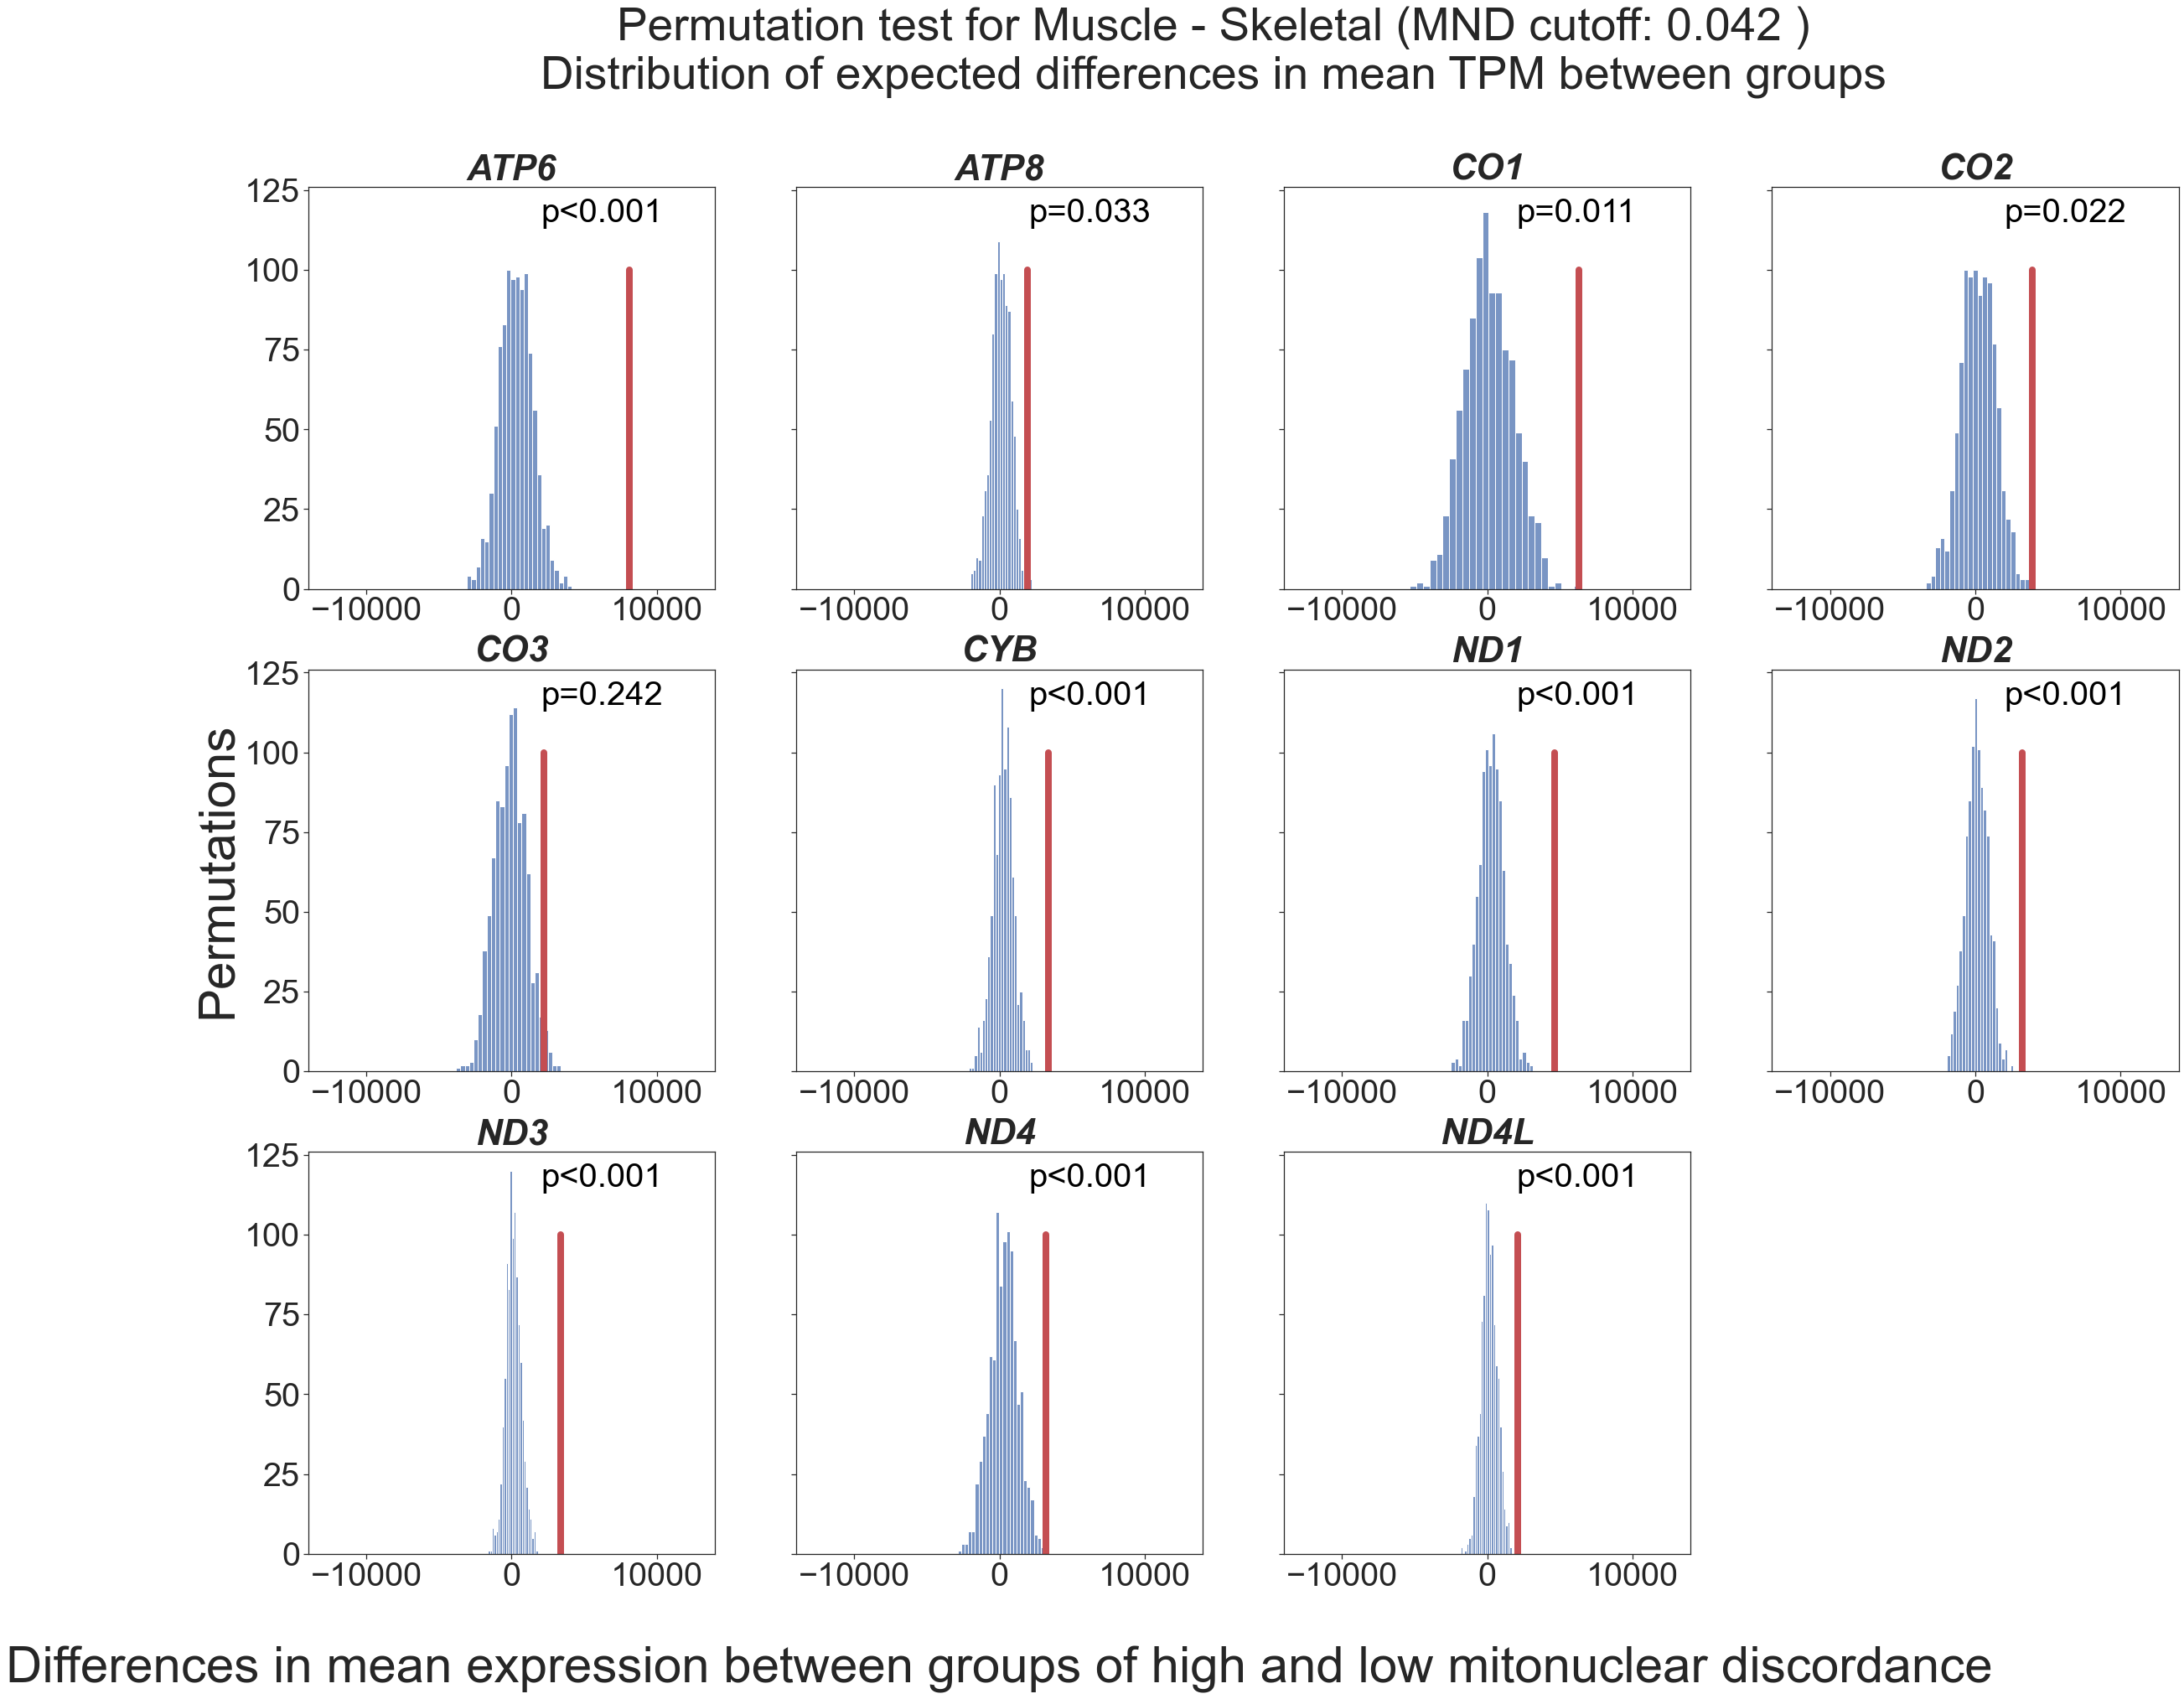

In [100]:
# Figure 3A: Plot permutation results for Skeletal muscle.
subplot_perm(df_adjTPM,'Muscle - Skeletal',list_mtdna,'Residuals_AgeIsch','mean')

In [18]:
# Table summarizing permutation results.
table_perm = table_permut_mnd_tpm(df_adjTPM,list_tissues,'Residuals_AgeIsch','mean')
table_perm

,Tissue,Gene,Cutoff_MND,Obs_diff,P-value,Bonferroni p-value
0,Muscle - Skeletal,ATP6,0.042487,8104.693645,0.000,<0.001
1,Muscle - Skeletal,ATP8,0.042487,1945.268385,0.003,0.033
2,Muscle - Skeletal,CO1,0.042487,6317.959008,0.001,0.011
3,Muscle - Skeletal,CO2,0.042487,3943.150414,0.002,0.022
4,Muscle - Skeletal,CO3,0.042487,2262.409984,0.022,0.242
5,Muscle - Skeletal,CYB,0.042487,3361.770754,0.000,<0.001
6,Muscle - Skeletal,ND1,0.042487,4651.455062,0.000,<0.001
7,Muscle - Skeletal,ND2,0.042487,3255.115157,0.000,<0.001
8,Muscle - Skeletal,ND3,0.042487,3382.139583,0.000,<0.001
9,Muscle - Skeletal,ND4,0.042487,3222.593246,0.000,<0.001


### Cutoff values used for permutation tests.

In [19]:
table_perm[['Tissue','Cutoff_MND']].drop_duplicates()

,Tissue,Cutoff_MND
0,Muscle - Skeletal,0.042487
11,Esophagus - Muscularis,0.047615
22,Artery - Tibial,0.048465
33,Nerve - Tibial,0.045895
44,Whole Blood,0.045706
55,Heart - Left Ventricle,0.043616
66,Heart - Atrial Appendage,0.033720
